# Assignment 4 - Solving a finite element system

This assignment makes up 30% of the overall marks for the course. The deadline for submitting this assignment is **5pm on Thursday 15 December 2022**.

Coursework is to be submitted using the link on Moodle. You should submit a single pdf file containing your code, the output when you run your code, and your answers
to any text questions included in the assessment. The easiest ways to create this file are:

- Write your code and answers in a Jupyter notebook, then select File -> Download as -> PDF via LaTeX (.pdf).
- Write your code and answers on Google Colab, then select File -> Print, and print it as a pdf.

Tasks you are required to carry out and questions you are required to answer are shown in bold below.

In [1]:
from scipy.sparse import coo_matrix
import numpy as np
from time import perf_counter

%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## The assignment

### Mathematical background
In this assignment, we are going to solve a Helmholtz wave problem:

$$\begin{align*}
-\Delta u - k^2u &= 0&\text{in }\Omega,\\
u &= g&\text{on the boundary of }\Omega.
\end{align*}$$

As our domain we will use the unit square, ie $\Omega=[0,1]^2$.
In this assignment, we will use $k=5$ and

$$
g(x,y)=
\begin{cases}
\sin(4y)&\text{if }x=0,\\
\sin(3x)&\text{if }y=0,\\
\sin(3+4y)&\text{if }x=1,\\
\sin(3x+4)&\text{if }y=1.
\end{cases}
$$

The finite element method is a method that can approximately solve problems like this. We first split the square $[0,1]^2$ into a mesh of $N$ squares by $N$ squares
(or $N+1$ points by $N+1$ points - 
note that there are $N$ squares along each side, but $N+1$ points along each side (watch out for off-by-one errors)):

![A mesh of $N$ squares by $N$ squares](2022a4-mesh.png)

As shown in the diagram, we let $h=1/N$.

The (degree 1) finite element method looks for an approximate solution by placing an unknown value/variable at each point, and approximating the solution as some
linear combination of the functions $1$, $x$, $y$ and $xy$ inside each square. Re-writing the problem as an integral equation (and doing a bit of algebra) allows
us to turn the problem into the matrix vector problem

$$\mathrm{A}\mathbf{x}=\mathbf{b}.$$

(We do not need to go into details of how this method is derived, but if you're curious, the first chapter of
*Numerical Solution of Partial Differential Equations by the Finite Element Method* by Claes Johnson
gives a good introduction to this method.)

Let $\mathbf{p}_0$, $\mathbf{p}_1$, ..., $\mathbf{p}_{(N-1)^2-1}$ be the points in our mesh that are not on the boundary (in some order). Let $x_0$, $x_1$, ..., $x_{(N-1)^2-1}$ be
the values/variables at the points (these are the entries of the unknown vector $\mathbf{x}$).

$\mathrm{A}$ is an $(N-1)^2$ by $(N-1)^2$ matrix. $\mathbf{b}$ is a vector with $(N-1)^2$ entries. The entries $a_{i,j}$ of the matrix $\mathrm{A}$ are given by

$$
a_{i,j} =\begin{cases}
\displaystyle
\frac{24-4h^2k^2}{9}&\text{if }i=j\\
\displaystyle
\frac{-3-h^2k^2}{9}
&\text{if }\mathbf{p}_i\text{ and }\mathbf{p}_j\text{ are horizontally or vertically adjacent}\\
\displaystyle
\frac{-12-h^2k^2}{36}
&\text{if }\mathbf{p}_i\text{ and }\mathbf{p}_j\text{ are diagonally adjacent}\\
0&\text{otherwise}
\end{cases}
$$

The entries $b_j$ of the vector $\mathbf{b}$ are given by

$$
b_{j} =\begin{cases}
\displaystyle
\frac{12+h^2k^2}{36}\left(g(0,0)+g(2h,0)+g(0,2h)\right)+\frac{3+h^2k^2}{9}\left(g(h,0)+g(0, h)\right)
&\text{if }\mathbf{p}_j=(h,h)\\
\displaystyle
\frac{12+h^2k^2}{36}\left(g(1,0)+g(1,2h)+g(1-2h,0)\right)+\frac{3+h^2k^2}{9}\left(g(1-h,0)+g(1, h)\right)
&\text{if }\mathbf{p}_j=(1-h,h)\\
\displaystyle
\frac{12+h^2k^2}{36}\left(g(0,1)+g(2h,1)+g(0,1-2h)\right)+\frac{3+h^2k^2}{9}\left(g(h,1)+g(0, 1-h)\right)
&\text{if }\mathbf{p}_j=(h,1-h)\\
\displaystyle
\frac{12+h^2k^2}{36}\left(g(1,1)+g(1-2h,1)+g(1,1-2h)\right)+\frac{3+h^2k^2}{9}\left(g(1-h,1)+g(1, 1-h)\right)
&\text{if }\mathbf{p}_j=(1-h,1-h)\\
\\[3mm]
\displaystyle
\frac{12+h^2k^2}{36}\left(g(0,c_j+h)+g(0,c_j-h)\right)+
\frac{3+h^2k^2}{9} g(0,c_j)
&\text{if }\mathbf{p}_j=(h,c_j)\text{, with }c_j\not=h\text{ and }c_j\not=1-h\\
\displaystyle
\frac{12+h^2k^2}{36}\left(g(1,c_j+h)+g(1,c_j-h)\right)+
\frac{3+h^2k^2}{9} g(1,c_j)
&\text{if }\mathbf{p}_j=(1-h,c_j)\text{, with }c_j\not=h\text{ and }c_j\not=1-h\\
\displaystyle
\frac{12+h^2k^2}{36}\left(g(c_j+h,0)+g(c_j-h,0)\right)+
\frac{3+h^2k^2}{9} g(c_j,0)
&\text{if }\mathbf{p}_j=(c_j,h)\text{, with }c_j\not=h\text{ and }c_j\not=1-h\\
\displaystyle
\frac{12+h^2k^2}{36}\left(g(c_j+h,1)+g(0,c_j-h,1)\right)+
\frac{3+h^2k^2}{9} g(c_j,1)
&\text{if }\mathbf{p}_j=(c_j,1-h)\text{, with }c_j\not=h\text{ and }c_j\not=1-h
\\[3mm]
0&\text{otherwise}
\end{cases}
$$

You could alternatively write this as

$$\begin{align*}
b_j &= \frac{12+h^2k^2}{36}
\left(\text{sum of evaluations of $g$ at all points on the boundary that are diagonally adjacent to $\mathbf{p}_j$}\right)
\\&\hspace{5mm}+
\frac{3+h^2k^2}{9}
\left(\text{sum of evaluations of $g$ at all points on the boundary that are horizontally or vertically adjacent to $\mathbf{p}_j$}\right)
\end{align*}$$

For example (using $k$ and $g$ as given above) when $N=2$, 

$$
\mathrm{A}=\begin{pmatrix}
-0.11111111
\end{pmatrix}.
$$

For $N=2$, the definition of $\mathbf{b}$ is different to above, as the point at $(1/2,1/2)$ is adjacent to all three sides and so the conditions above are all true at once.
The alternate value of $\mathbf{b}$ used in this case is not important, as we will later
take $N>2$.

As as second example, when $N=3$,

$$
\mathrm{A}=\begin{pmatrix}
 1.43209877& -0.64197531& -0.64197531& -0.41049383\\
-0.64197531&  1.43209877& -0.41049383& -0.64197531\\
-0.64197531& -0.41049383&  1.43209877& -0.64197531\\
-0.41049383& -0.64197531& -0.64197531&  1.43209877
\end{pmatrix},
$$

$$
\mathrm{b}=\begin{pmatrix}
1.72513230\\0.15334285\\-0.34843455\\-1.05586511
\end{pmatrix}.
$$

In this second example, I have numbered the points not on the boundary like this:

$$
\begin{array}{cc}
2&3\\
0&1
\end{array}
$$

### Part 1: creating the matrix and vector
**Write a function that takes $N$ as an input and returns the matrix $\mathrm{A}$ and the vector $\mathbf{b}$**. The matrix should be stored using an appropriate sparse format - you may use Scipy for this, and do not need to implement your own format.

You can find [example matrices and vectors for $N=2$, $N=3$, and $N=4$ here](2022-a4-A_and_b.md). You may wish to use them to validate your function, but you do not need to include this validation as
part of the assignment.

In [2]:
# A and b for N=2
A_2 = np.array([
    [-0.11111111111111116],
])
b_2 = np.array([0.2699980311833446])

# A and b for N=3
A_3 = np.array([
    [1.4320987654320987, -0.6419753086419753, -0.6419753086419753, -0.4104938271604938],
    [-0.6419753086419753, 1.4320987654320987, -0.4104938271604938, -0.6419753086419753],
    [-0.6419753086419753, -0.4104938271604938, 1.4320987654320987, -0.6419753086419753],
    [-0.4104938271604938, -0.6419753086419753, -0.6419753086419753, 1.4320987654320987],
])
b_3 = np.array([1.7251323007221917, 0.15334285313223067, -0.34843455260733003, -1.0558651156722307])

# A and b for N=4
A_4 = np.array([
    [1.972222222222222, -0.5069444444444444, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0, 0.0, 0.0, 0.0],
    [-0.5069444444444444, 1.972222222222222, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111, 0.0, 0.0, 0.0],
    [0.0, -0.5069444444444444, 1.972222222222222, 0.0, -0.3767361111111111, -0.5069444444444444, 0.0, 0.0, 0.0],
    [-0.5069444444444444, -0.3767361111111111, 0.0, 1.972222222222222, -0.5069444444444444, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0],
    [-0.3767361111111111, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, 1.972222222222222, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111],
    [0.0, -0.3767361111111111, -0.5069444444444444, 0.0, -0.5069444444444444, 1.972222222222222, 0.0, -0.3767361111111111, -0.5069444444444444],
    [0.0, 0.0, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0, 1.972222222222222, -0.5069444444444444, 0.0],
    [0.0, 0.0, 0.0, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, 1.972222222222222, -0.5069444444444444],
    [0.0, 0.0, 0.0, 0.0, -0.3767361111111111, -0.5069444444444444, 0.0, -0.5069444444444444, 1.972222222222222],
])
b_4 = np.array([1.4904895819530766, 1.055600747809247, 0.07847904705126368, 0.8311407883427149, 0.0, -0.8765020708205272, -0.6433980946818605, -0.7466392365712349, -0.538021498324083])

First I'll implement the function $g(x,y)$:
$$
g(x,y)=
\begin{cases}
\sin(4y)&\text{if }x=0,\\
\sin(3x)&\text{if }y=0,\\
\sin(3+4y)&\text{if }x=1,\\
\sin(3x+4)&\text{if }y=1.
\end{cases}
$$

In [3]:
def g(x, y):
    
    return np.sin(3*x + 4*y)

The next function is to help with converting a point's indices on the grid into a row index for a vector/column index for a matrix:

In [4]:
def pj_to_col(pj, N):
    
    #Remove any points which out out of bounds of the interior grid
    pj = pj[(pj[:,0] >= 0) & (pj[:,1] >= 0) 
                                  & (pj[:,0] < (N-1)) & (pj[:,1] < (N-1))]
    
    #Convert the grid indices into row/column indices
    return pj[:,0]*(N-1) + pj[:,1]

In [5]:
def helmholtz_fe(N):
    
    
    ###############################################
    #Set up constant values
    h = 1/N
    k = 5
    
    #Values for different entries
    diagonal = (24-4*h**2*k**2)/9
    hv_adjacent = (-3-1*h**2*k**2)/9
    d_adjacent = (-12-1*h**2*k**2)/36
    
    b_term1 = (12+h**2*k**2)/36
    b_term2 = (3+h**2*k**2)/9
    
    
    ###############################################
    #Initialize data storage

    #Number of elements is:
    #(N-1)^2 for the diagonal, 1 diagonal
    #The corners have 3 neighbors (1 diagonal, 1 horizontal, 1 vertical), there are 4 corners
    #edge points have 5 neighbors (2 diagonal, 3 mix of horizontal and vertical), there are 4(N-3) edge points
    #all other points have 8 neighbors (4 diagonal, 2 horizontal, 2 vertical), there are (N-1)^2 - 4(N-2) other points
    nelements = (N-1)**2 + 4*3 + (4*(N-3))*5 + ((N-1)**2 - 4*(N-2))*8
    
    #Set up coo styled data storage 
    row_ind = np.zeros(nelements, dtype=int)
    col_ind = np.zeros(nelements, dtype=int)
    data = np.zeros(nelements, dtype=np.float64)
    
    #Create the empty vector
    b = np.zeros((N-1)**2, dtype=np.float64)
    
    ##############################################################################################
    #Iterate through the matrix rows
    count = 0
    for row in range(0,(N-1)**2):
        
        #Work out p_(row) (starts at (0,0) meaning (x=h, y=h) then -> (0,1) meaning (x=2h, y=h) )
        p_i = (row//(N-1), row%(N-1))
        
        ###############################################
        #Find columns where p_(row) is horizontally or vertically adjacent to p_(column)
        adjs = np.array([[p_i[0],p_i[1]-1],
                        [p_i[0],p_i[1]+1],
                        [p_i[0]-1,p_i[1]],
                        [p_i[0]+1,p_i[1]]])
        
        adjacent_cols = pj_to_col(adjs,N)
        
        n_adjacent = len(adjacent_cols)
        col_ind[count+1:count+1+n_adjacent] = adjacent_cols
        data[count+1:count+1+n_adjacent] = hv_adjacent
        
        ###############################################
        #Find columns where p_(row) is diagonally adjacent to p_(column)
        diags = np.array([[p_i[0]+1,p_i[1]+1],
                         [p_i[0]-1,p_i[1]-1],
                         [p_i[0]+1,p_i[1]-1],
                         [p_i[0]-1,p_i[1]+1]])
        
        diagonal_cols = pj_to_col(diags,N)
        
        n_diagonal = len(diagonal_cols)
        col_ind[count+1+n_adjacent:count+1+n_adjacent+n_diagonal] = diagonal_cols
        data[count+1+n_adjacent:count+1+n_adjacent+n_diagonal] = d_adjacent
          
        #################################################
        #Save the diagonals
        
        #Work out total number of non zero elements in the row
        n_in_row = 1+n_adjacent+n_diagonal
        
        #Save all row indices
        row_ind[count : count+n_in_row] = row
        
        #Save the diagonal
        col_ind[count] = row
        data[count] = diagonal

        count += n_in_row
        
        ##############################################
        #Save the vector data
        
        #Rescale the adjacent and diagonal values so that they account for h
        adjs = adjs*h+h
        diags = diags*h+h
        
        #Only keep adjacent and diagonal points which are on the boundary (have one coordinate a 0 or 1)
        adjs = adjs[(adjs[:,0] == 0) | (adjs[:,0] == 1) | (adjs[:,1] == 0) | (adjs[:,1] == 1)]
        diags = diags[(diags[:,0] == 0) | (diags[:,0] == 1) | (diags[:,1] == 0) | (diags[:,1] == 1) ]

        #Compute b_j
        b[row] = b_term1*np.sum(g(diags[:,1], diags[:,0])) + b_term2*np.sum(g(adjs[:,1], adjs[:,0]))
        
        ############################################## 
        
    ##############################################################################################

            
    return coo_matrix((data, (row_ind, col_ind)), shape=((N-1)**2, (N-1)**2)).tocsr(), b    
    


A quick check to see if the matrix and vector are as expected:

In [6]:
assert np.allclose(helmholtz_fe(2)[0].toarray(), A_2)
assert np.allclose(helmholtz_fe(3)[0].toarray(), A_3)
assert np.allclose(helmholtz_fe(4)[0].toarray(), A_4)

In [7]:
assert np.allclose(helmholtz_fe(2)[1], b_2)
assert np.allclose(helmholtz_fe(3)[1], b_3)
assert np.allclose(helmholtz_fe(4)[1], b_4)

### Part 2: solving the system
Solving the matrix-vector problem will lead to an approximate solution to the Helmholtz problem:
we call this approximate solution $u_h$.

Using any matrix-vector solver, **solve the matrix-vector problem for $N=4$, $N=8$, and $N=16$** and **plot the approximate solutions
to the Helmholtz problem**. To plot
the solutions, you can pass the $x$- and $y$-coordinates of the points and the value of $u_h$ at each
point into matplotlib's 3D plotting function. For the points on the boundary, the value of $u_h$ is
given by the function $g$; for interior points, the value will be one of the entries of the solution
vector $\mathbf{x}$.

An example of 3D plotting in matplotlib can be found in the [sparse PDE example](sparse_linalg_pde.ipynb) from earlier in the course.

In [8]:
from scipy.sparse.linalg import spsolve

In [9]:
def plot_solution(N):
    
    #Generate the matrix and vector
    A, f = helmholtz_fe(N)
    
    #Solve the problem for the interior points - using scipy spsolve
    sol = spsolve(A, f)
    u = sol.reshape((N-1, N-1))
    
    #Evaluate the boundary points
    ticks= np.linspace(0, 1, N+1)
    X, Y = np.meshgrid(ticks, ticks)
    u_full = g(X, Y) #This evaluates g for the full grid
    u_full[1:N, 1:N] = u #Replace the interior points with the matrix vector solutions
    
    #Plot
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, u_full, antialiased=True, cmap=cm.inferno)
    plt.show() 

<IPython.core.display.Javascript object>


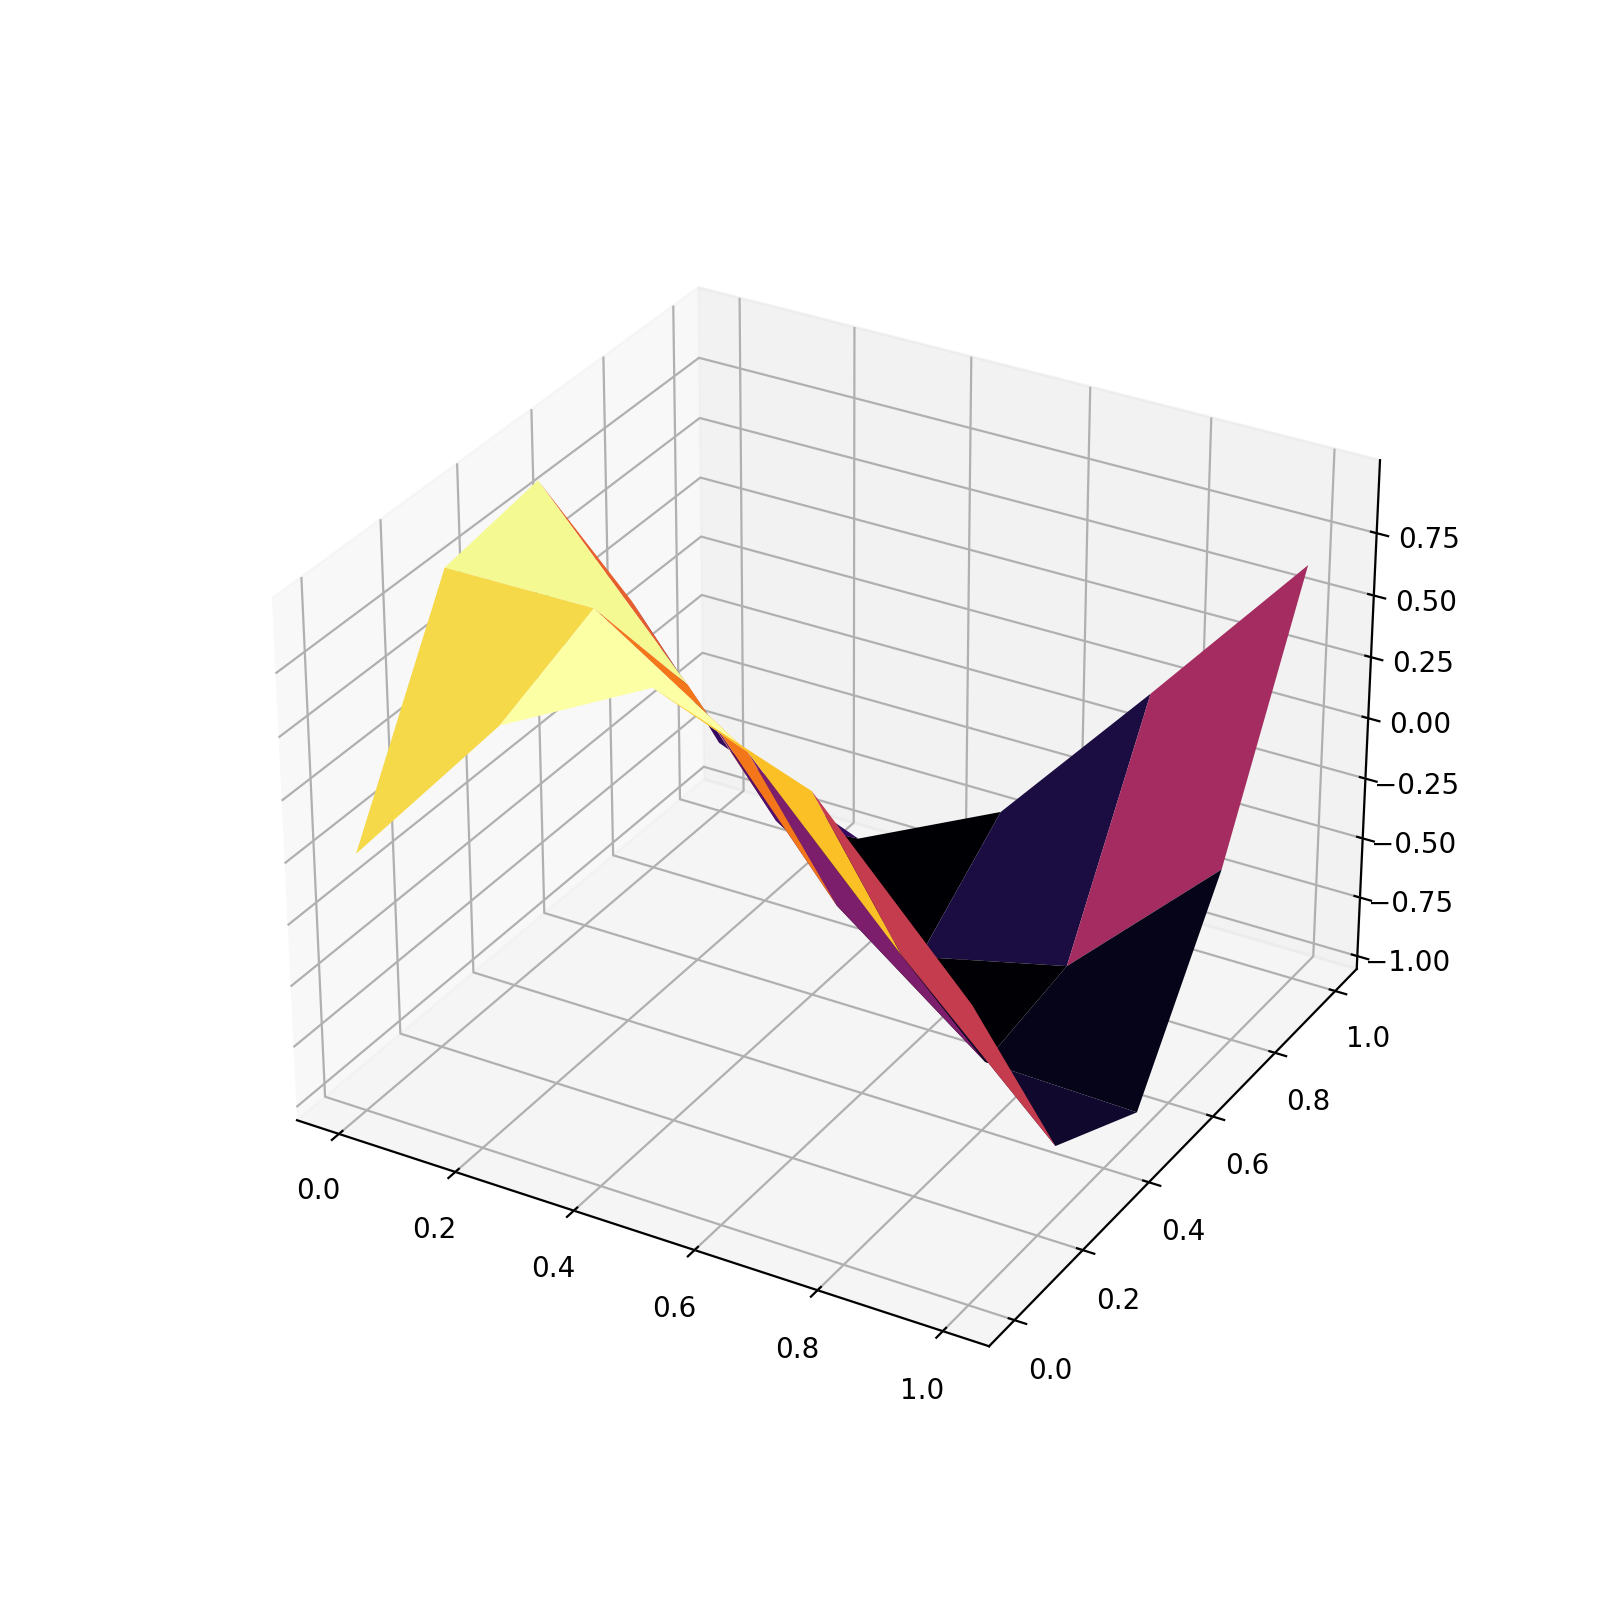

In [10]:
plot_solution(4)

<IPython.core.display.Javascript object>


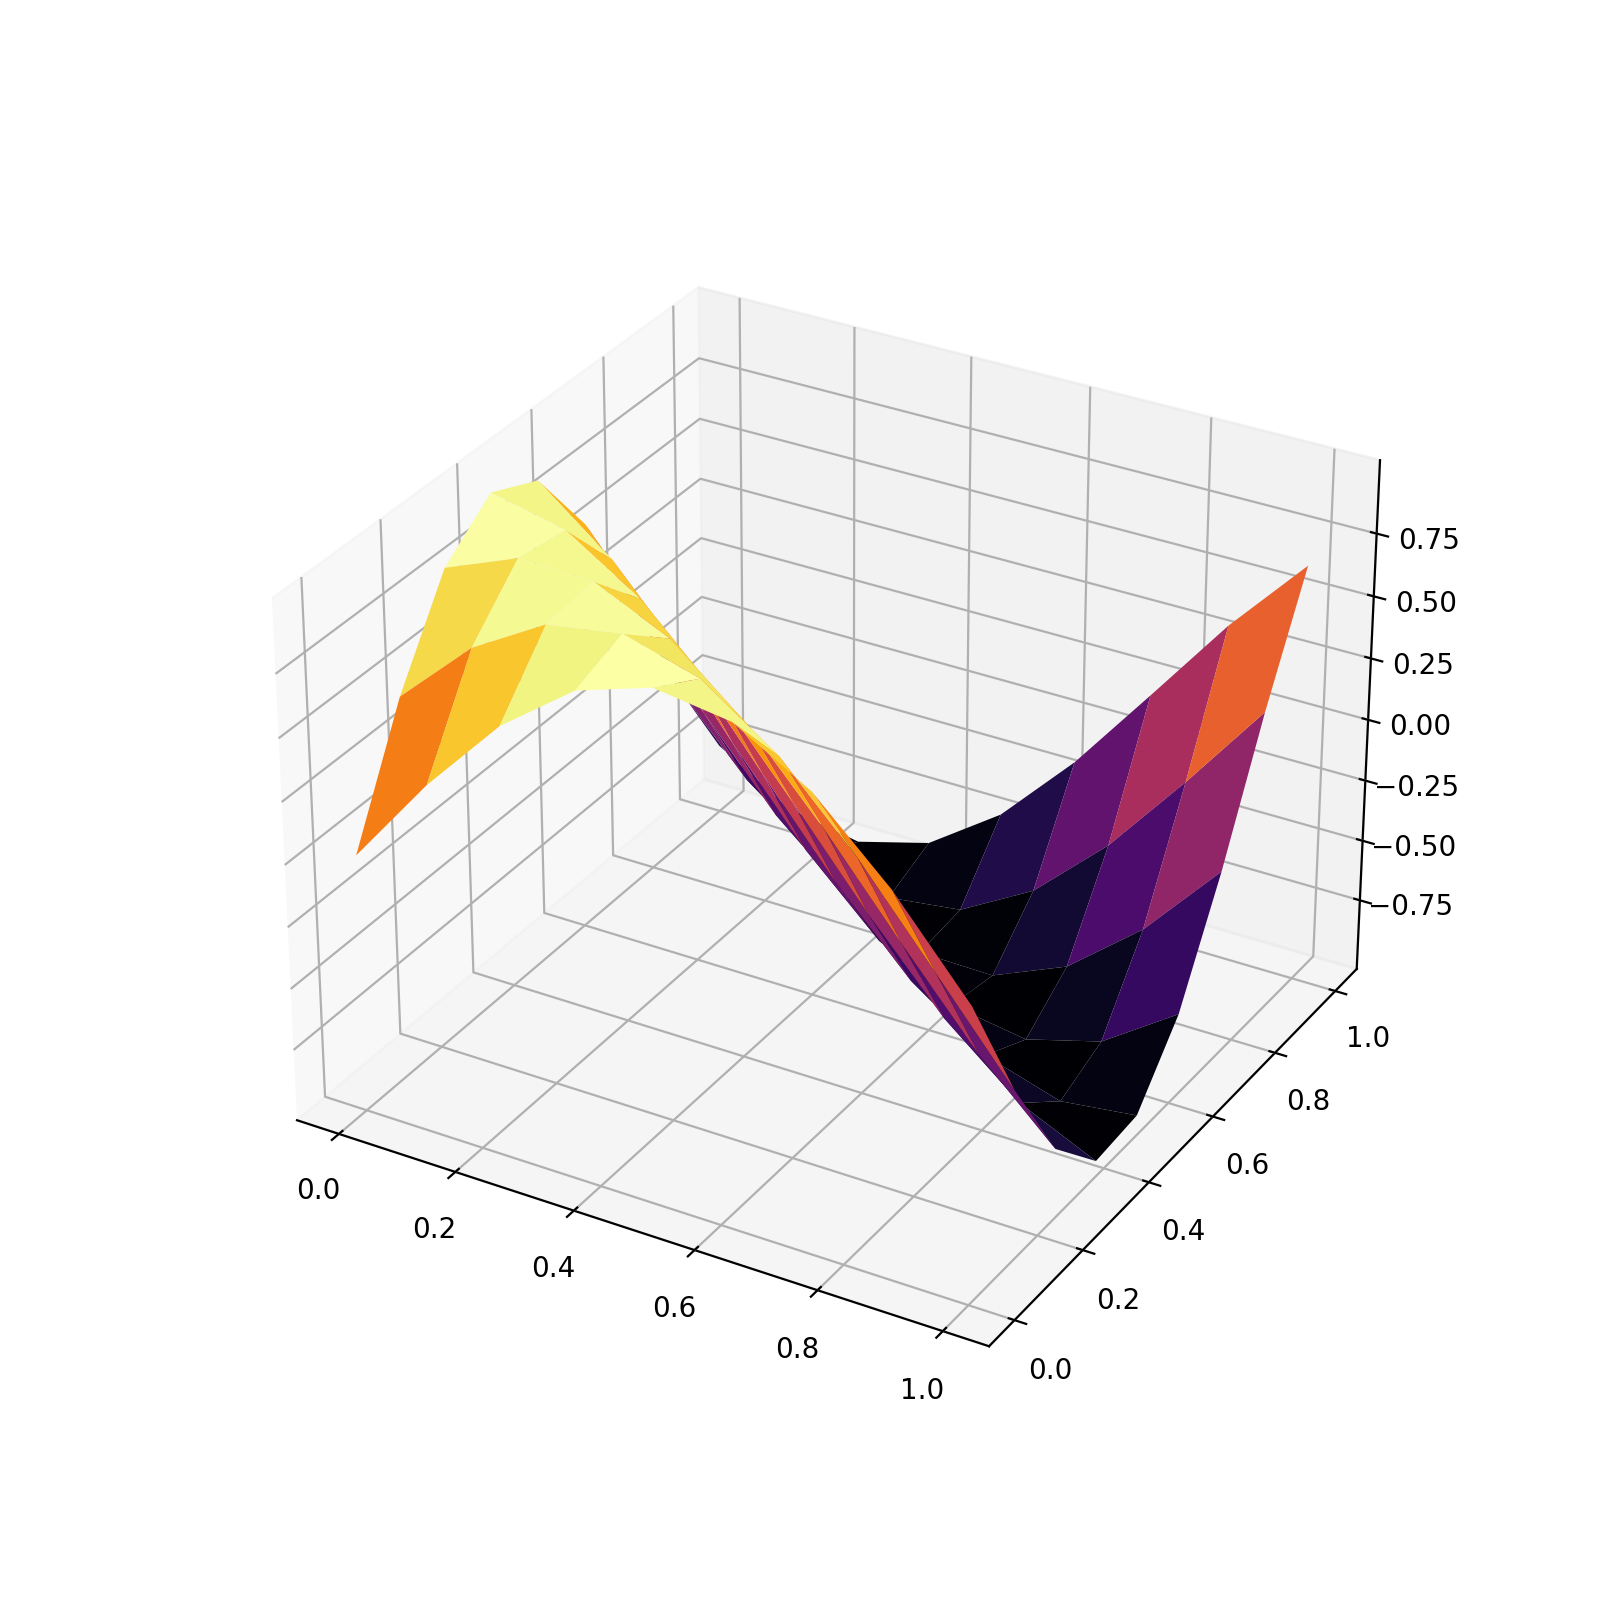

In [11]:
plot_solution(8)

<IPython.core.display.Javascript object>


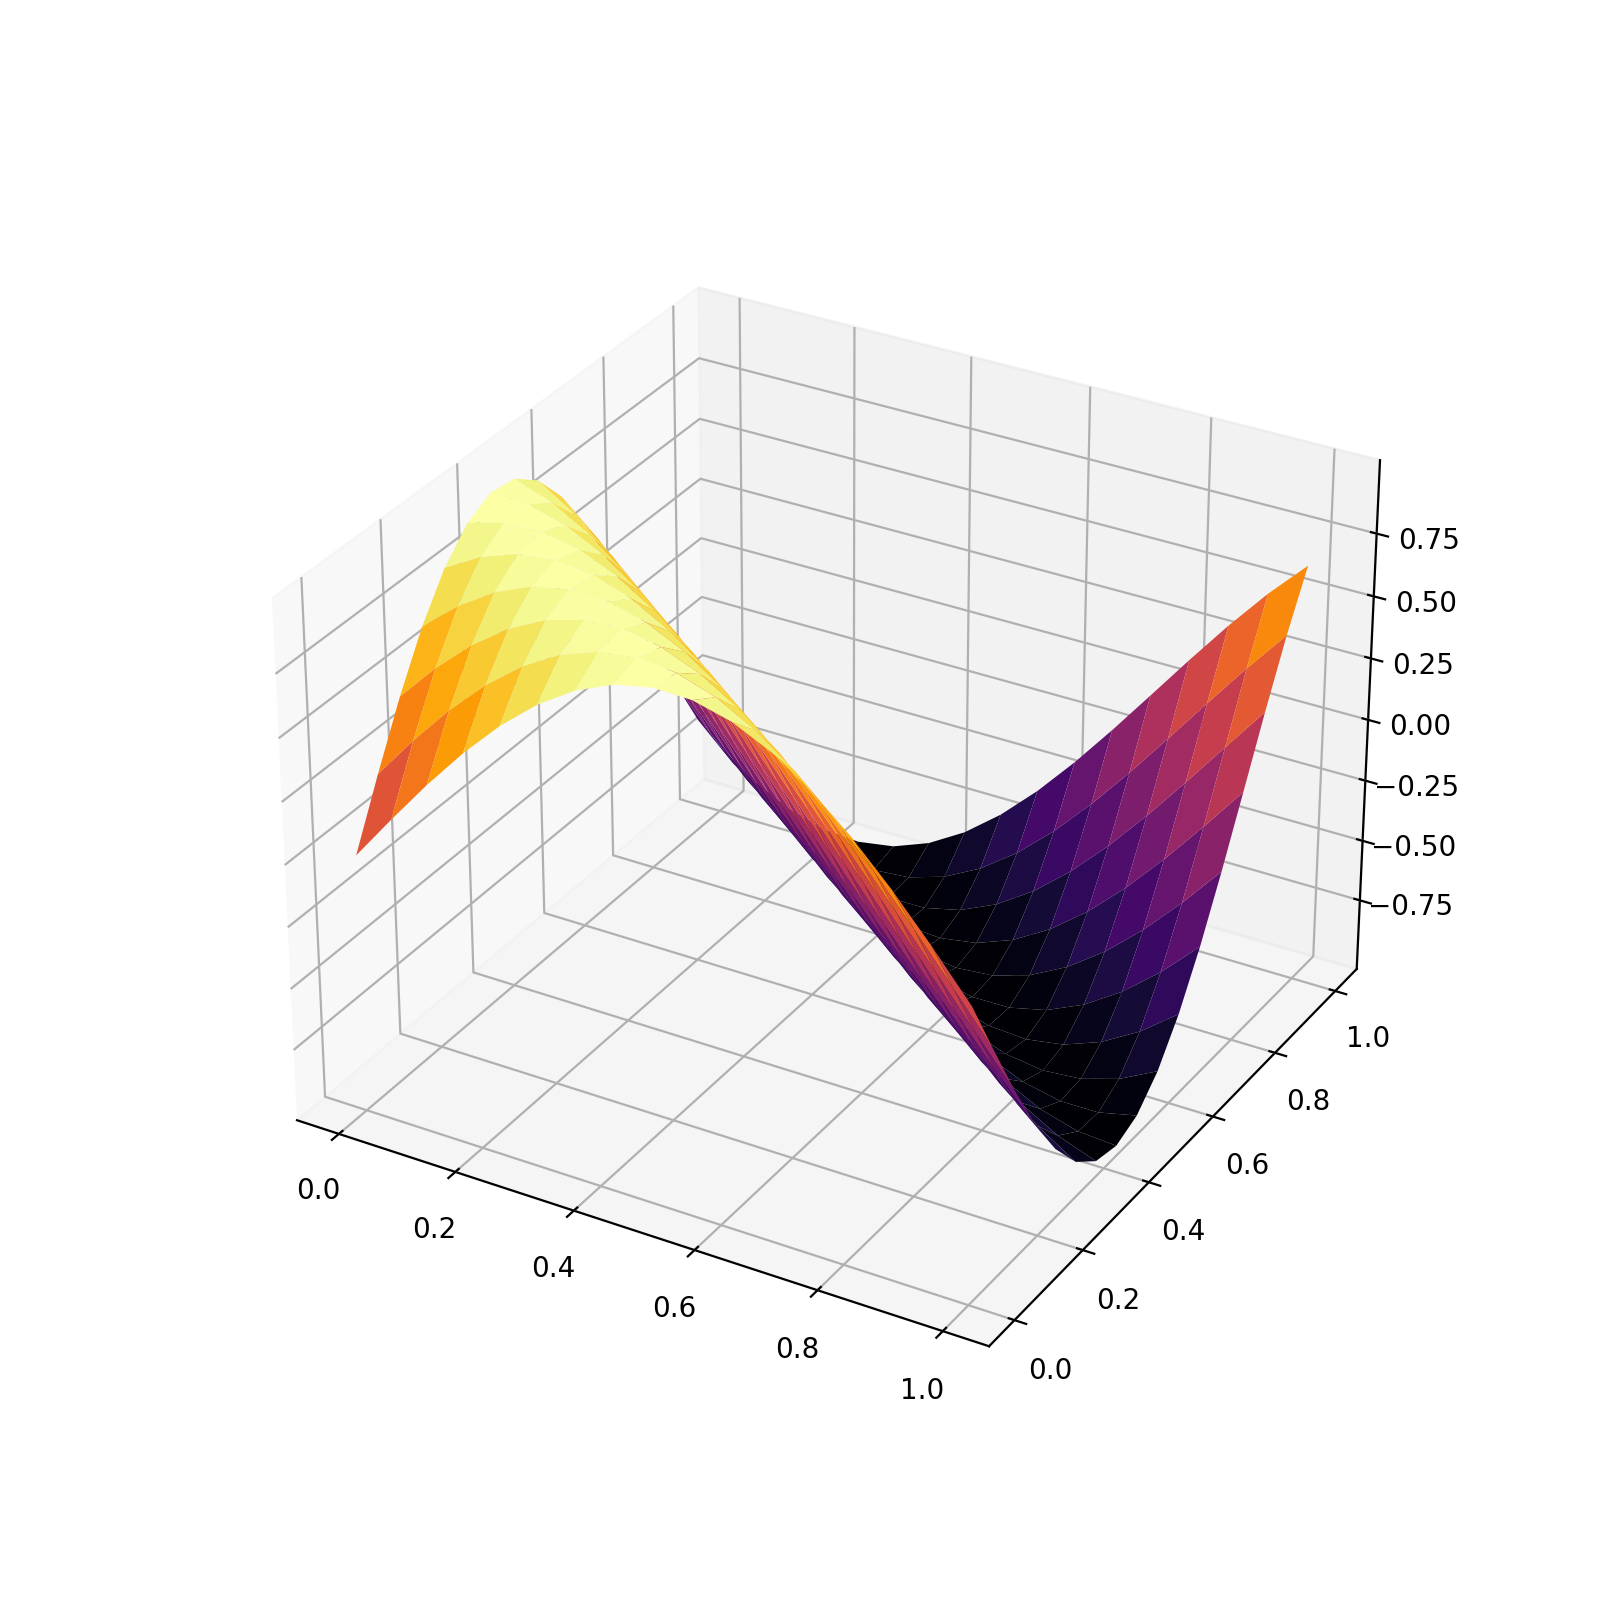

In [12]:
plot_solution(16)

### Part 3: comparing solvers and preconditioners
In this section, your task is to evaluate the performance of various matrix-vector solvers.
To do this, **solve the matrix-vector problem with small to medium sized value of $N$ using a range of different solvers of your choice,
measuring factors you deem to be important for your evaluation.** These factors should include
the time taken by the solver, and may additionally include many other thing such as the number of
iterations taken by an iterative solver, or the size of the residual after each iteration.
**Make a set of plots that show the measurements you have made and allow you to compare the solvers**.

You should compare at least five matrix-vector solvers: at least two of these should be iterative
solvers, and at least one should be a direct solver. You should use some solvers from the Scipy
library and some from PETSc. (You may optionally use additional solvers from other linear algebra
libraries, but you do not need to do this to achieve high marks. You should use solvers from these libraries and do not need to implement your own solvers.)
For two of the iterative solvers you have chosen to use,
**repeat the comparisons with three different choices of preconditioner**.

In [13]:
import pandas as pd

For this section I will use the following matrix vector problem solvers:

| Solver | type |
|---|---|
|`scipy.gmres`| iterative |
|`scipy.cg`| iterative |
|`scipy.bicgstab`| iterative |
|`scipy.spsolve`| direct |
|`scipy.splu`| direct |
|`scipy.gmres` + preconditioning| iterative with preconditioning |
|`scipy.bicgstab` + preconditioning| iterative with preconditioning|
|`PETSc.bcgs`| iterative |
|`PETSc.gmres`| iterative |
|`PETSc.directlu`| direct |

I will evaluate them on the following set of metrics: `{run_time, no_iterations, final_residual}`

Below is an object for keeping track of the number of iterations an iterative solver took:

In [156]:
class counter(object):
    def __init__(self):
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1

In [157]:
#We will test each solver 5 times
test_iters = 5

#We will use a range of ns from 2 up to 29
Ns = np.arange(2,30).repeat(test_iters)

#We will define m for the precondtioning section
m = 1

metrics = pd.DataFrame({"Name" : []
                       })

I will use spai preconditioning

In [158]:
def spai(A, m):
    """Perform m step of the SPAI iteration."""
    from scipy.sparse import identity
    from scipy.sparse import diags
    from scipy.sparse.linalg import onenormest
    
    n = A.shape[0]
    
    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A
        
    for index in range(m):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G
        
    return M

#### Testing scipy.spsolve

In [159]:
spsolve_times = []

for N in Ns:
    #Check run time
    start = perf_counter()
    A, f = helmholtz_fe(N)
    sol = spsolve(A, f)
    spsolve_times.append(perf_counter() - start)
    
    
metrics = metrics.append(pd.DataFrame({"Name" : "scipy.spsolve",
                                       "Ns" : Ns,
                                       "Times" : spsolve_times
                                      }))

#### Testing scipy.gmres

In [160]:
from scipy.sparse.linalg import gmres

In [161]:
gmres_times = []
gmres_iters = []
gmres_residuals = []

for N in Ns:
    #Check run time
    start = perf_counter()
    A, f = helmholtz_fe(N)
    count = counter()
    sol = gmres(A, f, callback=count)
    gmres_times.append(perf_counter() - start)
        
    #Count the number of iterations it took to run
    gmres_iters.append(count.niter)
    
    #Save the final residual
    gmres_residuals = sol[1]
     
metrics = metrics.append(pd.DataFrame({"Name" : "scipy.gmres",
                                       "Ns" : Ns,
                                       "Times" : gmres_times,
                                       "Iterations" : gmres_iters,
                                       "Residual" : gmres_residuals
                                      }))

Applying preconditioning

In [162]:
pre_gmres_times = []
pre_gmres_iters = []
pre_gmres_residuals = []

for N in Ns:
    #Check run time
    start = perf_counter()
    A, f = helmholtz_fe(N)
    count = counter()
    M = spai(A, m)
    sol = gmres(A, f, M = M, callback=count)
    pre_gmres_times.append(perf_counter() - start)
        
    #Count the number of iterations it took to run
    pre_gmres_iters.append(count.niter)
    
    #Save the final residual
    pre_gmres_residuals = sol[1]

metrics = metrics.append(pd.DataFrame({"Name" : "pre_scipy.gmres",
                                       "Ns" : Ns,
                                       "Times" : pre_gmres_times,
                                       "Iterations" : pre_gmres_iters,
                                       "Residual" : pre_gmres_residuals
                                      }))

#### Testing scipy.cg

In [163]:
from scipy.sparse.linalg import cg

In [164]:
cg_times = []
cg_iters = []
cg_residuals = []

for N in Ns:
    #Check run time
    start = perf_counter()
    A, f = helmholtz_fe(N)
    count = counter()
    sol = gmres(A, f, callback=count)
    cg_times.append(perf_counter() - start)
    
    #Count the number of iterations it took to run
    cg_iters.append(count.niter)
    
    #Save the final residual
    cg_residuals = sol[1]
    
metrics = metrics.append(pd.DataFrame({"Name" : "scipy.cg",
                                       "Ns" : Ns,
                                       "Times" : cg_times,
                                       "Iterations" : cg_iters,
                                       "Residual" : cg_residuals
                                      }))

#### Testing scipy.bicgstab

In [165]:
from scipy.sparse.linalg import bicgstab

In [166]:
bicgstab_times = []
bicgstab_iters = []
bicgstab_residuals = []

for N in Ns:
    #Check run time
    start = perf_counter()
    A, f = helmholtz_fe(N)
    
    count = counter()
    sol = bicgstab(A, f, callback=count)
    bicgstab_times.append(perf_counter() - start)
    
    #Count the number of iterations it took to run
    bicgstab_iters.append(count.niter)
    
    #Save the final residual
    bicgstab_residuals = sol[1]
    
metrics = metrics.append(pd.DataFrame({"Name" : "scipy.bicgstab",
                                       "Ns" : Ns,
                                       "Times" : bicgstab_times,
                                       "Iterations" : bicgstab_iters,
                                       "Residual" : bicgstab_residuals
                                       }))

We will also apply preconditioning to this method

In [167]:
pre_bicgstab_times = []
pre_bicgstab_iters = []
pre_bicgstab_residuals = []

for N in Ns:
    #Check run time
    start = perf_counter()
    A, f = helmholtz_fe(N)
    count = counter()
    M = spai(A, m)
    sol = bicgstab(A, f, M = M, callback=count)
    pre_bicgstab_times.append(perf_counter() - start)
    
    #Count the number of iterations it took to run
    pre_bicgstab_iters.append(count.niter)
    
    #Save the final residual
    pre_bicgstab_residuals = sol[1]
    
metrics = metrics.append(pd.DataFrame({"Name" : "pre_scipy.bicgstab",
                                       "Ns" : Ns,
                                       "Times" : pre_bicgstab_times,
                                       "Iterations" : pre_bicgstab_iters,
                                       "Residual" : pre_bicgstab_residuals
                                       }))

#### Testing scipy.splu.solve()

In [168]:
from scipy.sparse.linalg import splu

In [169]:
triangular_times = []

for N in Ns:
    #Check run time
    start = perf_counter()
    A, f = helmholtz_fe(N)
    sol = splu(A).solve(f)
    triangular_times.append(perf_counter() - start)
    
metrics = metrics.append(pd.DataFrame({"Name" : "scipy.splu",
                                       "Ns" : Ns,
                                       "Times" : triangular_times
                                       }))

/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Based on your experiments, **pick a solver** (and a preconditioner if it improves the solver)
that you think is most appropriate to solve this matrix-vector problem. **Explain, making use
of the data from your experiments, why this is the best solver for this problem**.

In [170]:
import seaborn as sns

#### Run time

<IPython.core.display.Javascript object>


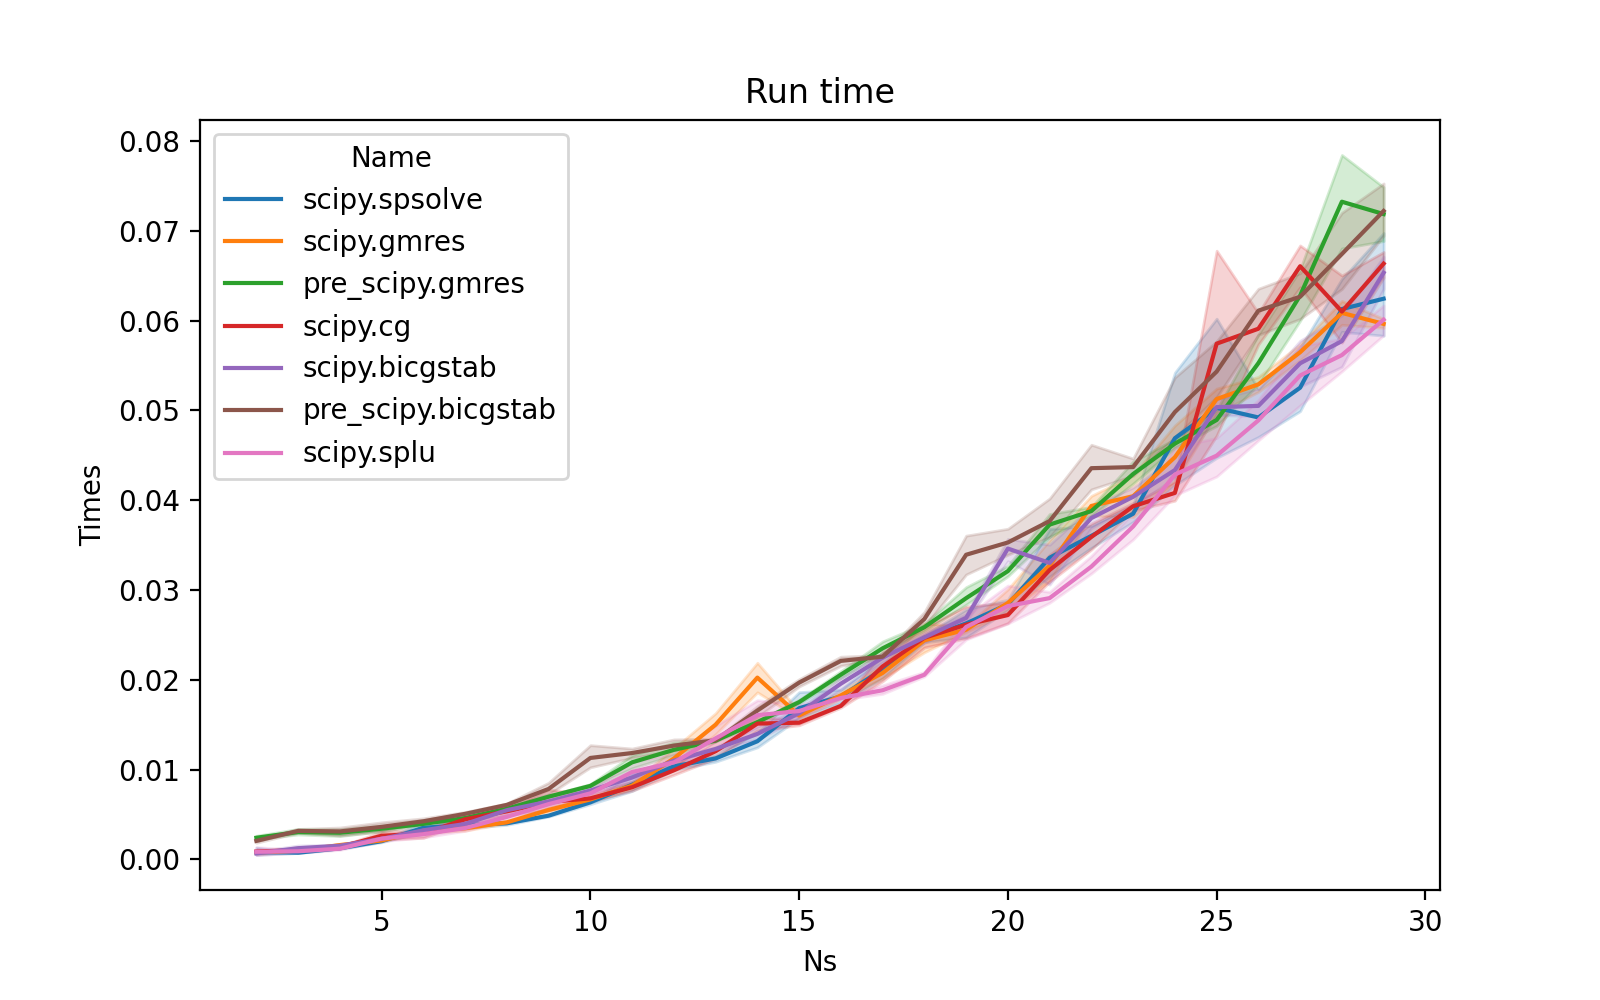

In [194]:
f, ax = plt.subplots(figsize=(8, 5))
ax.set(title="Run time")
sns.lineplot(data = metrics, x = "Ns", y = "Times", ax = ax, hue = 'Name');

#### Number of iterations required

<IPython.core.display.Javascript object>


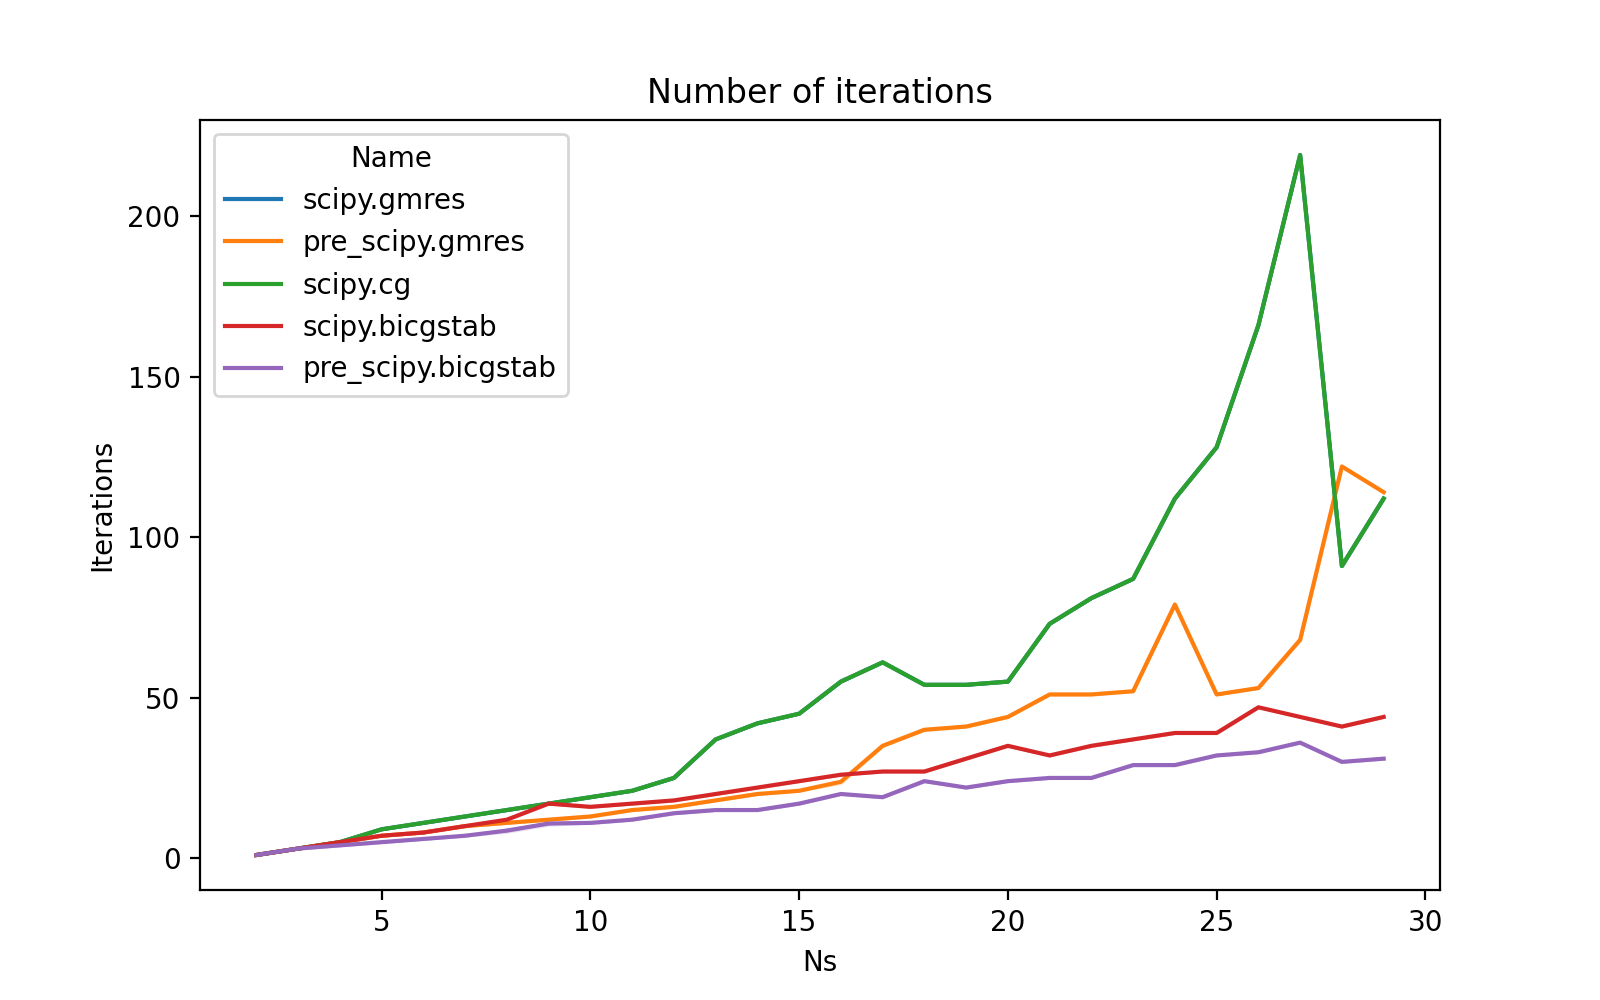

In [195]:
f, ax = plt.subplots(figsize=(8, 5))
ax.set(title="Number of iterations")
sns.lineplot(data = metrics[metrics["Iterations"] > 0], x = "Ns", y = "Iterations", ax = ax, hue = 'Name');

#### Final residual

For the iterative method we can also view the final residual - this should be zero or very close to zero if the solver has worked

<IPython.core.display.Javascript object>


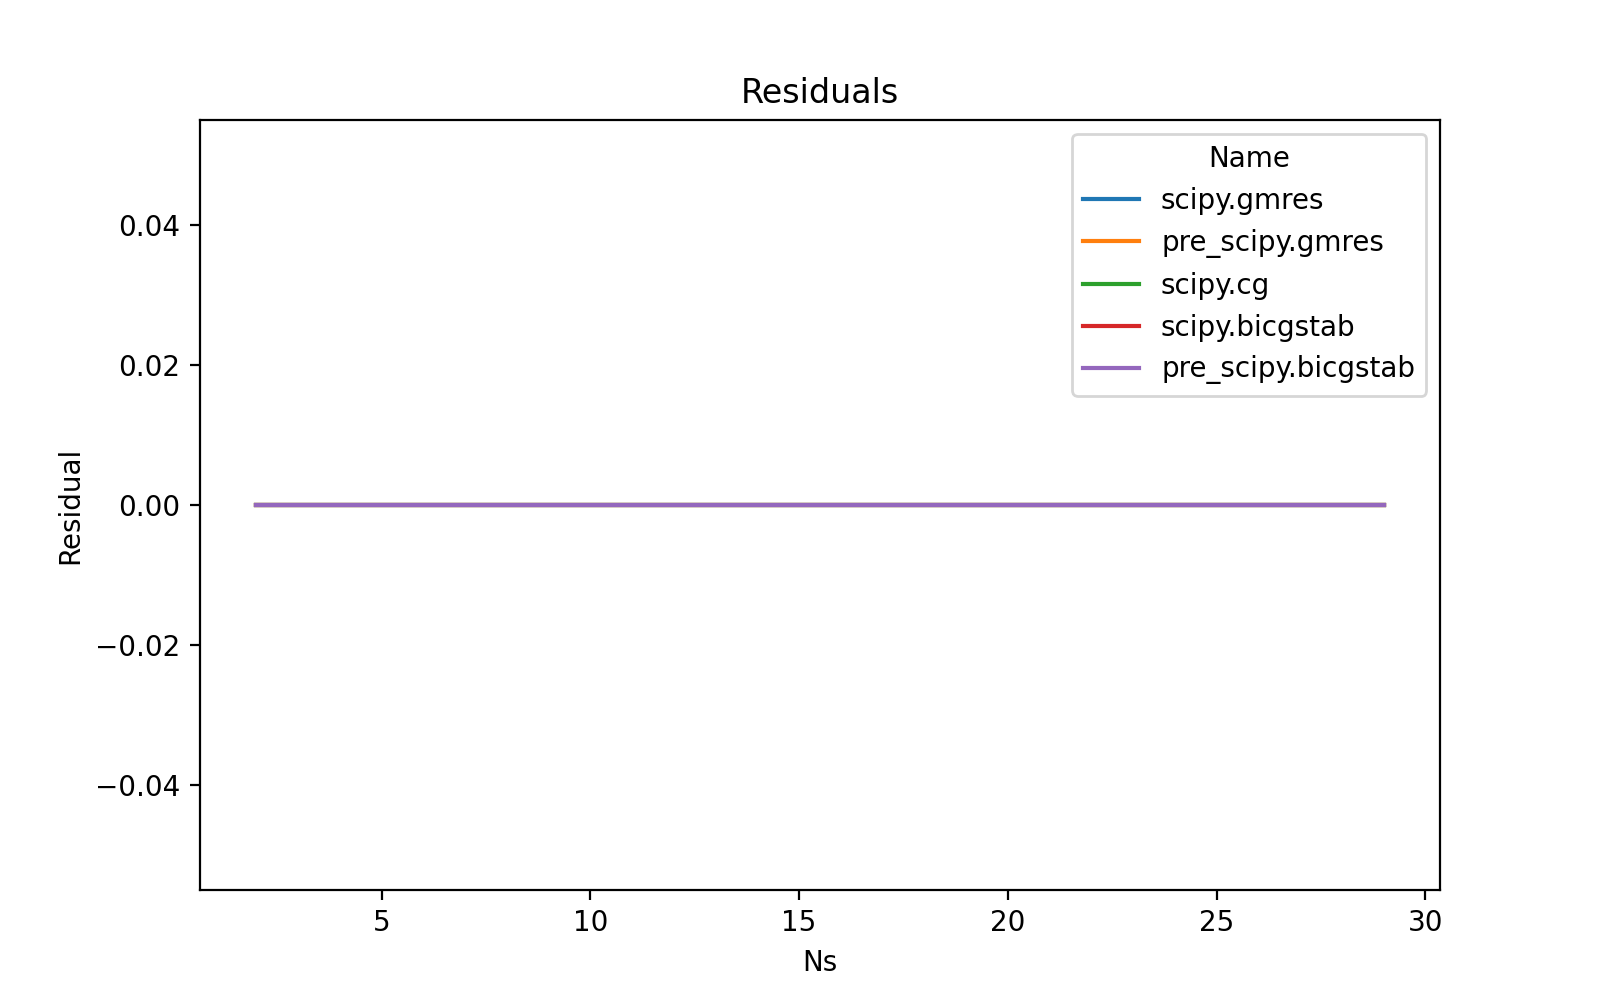

In [196]:
f, ax = plt.subplots(figsize=(8, 5))
ax.set(title="Residuals")
sns.lineplot(data = metrics[metrics["Residual"] >= 0], x = "Ns", y = "Residual", ax = ax, hue = 'Name');

### Part 4: increasing $N$
In this section, you are going to use the solver you picked in part 3 to compute the solution
for larger values of $N$.

The problem we have been solving in this assignment has the exact solution $u_\text{exact}=\sin(3x+4y)$.
A measure of the error of an approximate solution $u_h$ can be computed using

$$
\sum_{i=0}^{N-1} h^2\left|u_\text{exact}(\mathbf{m}_i)-u_h(\mathbf{m}_i)\right|,
$$

where $\mathbf{m}_i$ is the midpoint of the $i$th square in the finite element mesh: the value of
$u_h$ at this midpoint will be the mean of the values at the four corners of the square.

For a range of values of $N$ from small to large, **compute the solution to the matrix-vector
problem**. **Measure the time taken to compute this solution**, and **compute the error of the solution**.
**Make plots showing the time taken and error as $N$ is increased**.

In [223]:
def get_error(sol, N):
    
    h = 1/N
    
    #Evaluate the boundary points
    ticks= np.linspace(0, 1, N+1)
    X, Y = np.meshgrid(ticks, ticks)
    u_exact = g(X, Y) #This evaluates g for the full grid
    
    u_h = g(X, Y) #keep the boundary points for the solved solution
    u_h[1:N, 1:N] = sol.reshape((N-1, N-1)) #Replace the interior points with the matrix vector solutions
    
    err = 0
    for i in range(0,(N)**2):
        p_i = (i//(N), i%(N))

        u_exact_mi = np.mean(u_exact[p_i[0]:p_i[0]+2,p_i[1]:p_i[1]+2])
        u_h_mi = np.mean(u_h[p_i[0]:p_i[0]+2,p_i[1]:p_i[1]+2])
        
        err += h**2*abs(u_exact_mi-u_h_mi)
        
    return err

In [232]:
errors = []
times = []
Ns = np.linspace(10,200,30, dtype=int)

for N in Ns:
    
    #Check run time
    start = perf_counter()
    A, f = helmholtz_fe(N)
    sol = splu(A).solve(f)
    times.append(perf_counter() - start)

    #Check the error
    errors.append(get_error(sol, N))

/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


<IPython.core.display.Javascript object>


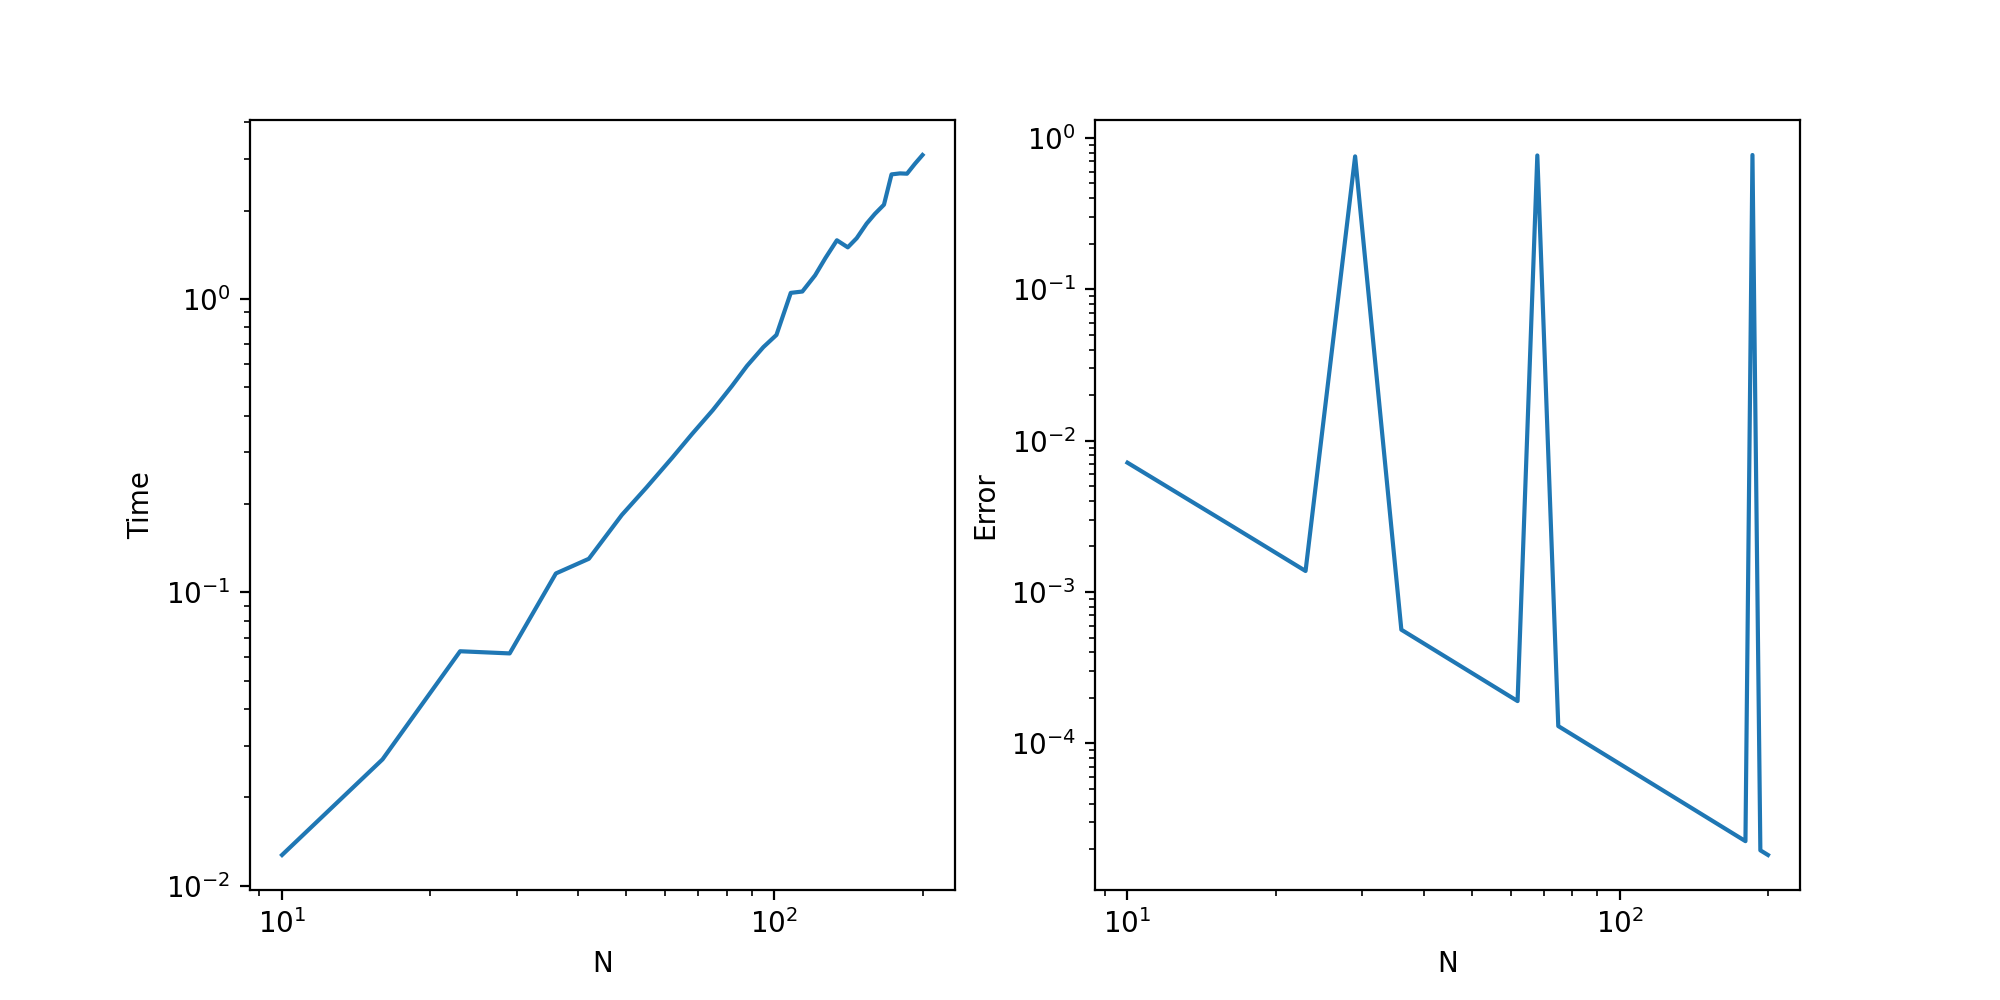

In [233]:
fig, ax = plt.subplots(1,2,figsize=(10, 5),dpi=100)

ax[0].plot(Ns, times)
ax[0].set_xlabel("N")
ax[0].set_ylabel("Time")
ax[0].set_xscale("log")
ax[0].set_yscale("log")

ax[1].plot(Ns, errors)
ax[1].set_xlabel("N")
ax[1].set_ylabel("Error")
ax[1].set_xscale("log")
ax[1].set_yscale("log");

Using your plots, **estimate the complexity of the solver you are using** (ie is it $\mathcal{O}(N)$?
Is it $\mathcal{O}(N^2)$?), and **estimate the order of convergence of your solution** (your error
should decrease like $\mathcal{O}(N^{-\alpha})$ for some $\alpha>0$). Briefly (1-2 sentences)
**comment on how you have made these estimates of the complexity and order.**

Both the time complexity and the error convergence appear to follow an exponential function. To find the exponent of this function, $\alpha$, I will fit a function, $AN^{\alpha}$, to the time and error data using the curve fit function from scipy:

In [234]:
from scipy.optimize import curve_fit

In [235]:
#Function to be fit
def f(x,A,alpha):
    
    return A*x**(alpha)

In [236]:
#Fit the exponential to the times
popt_times = curve_fit(f, Ns, times)[0]

#Fit the exponential to the errors
popt_err = curve_fit(f, Ns, errors)[0]

<IPython.core.display.Javascript object>


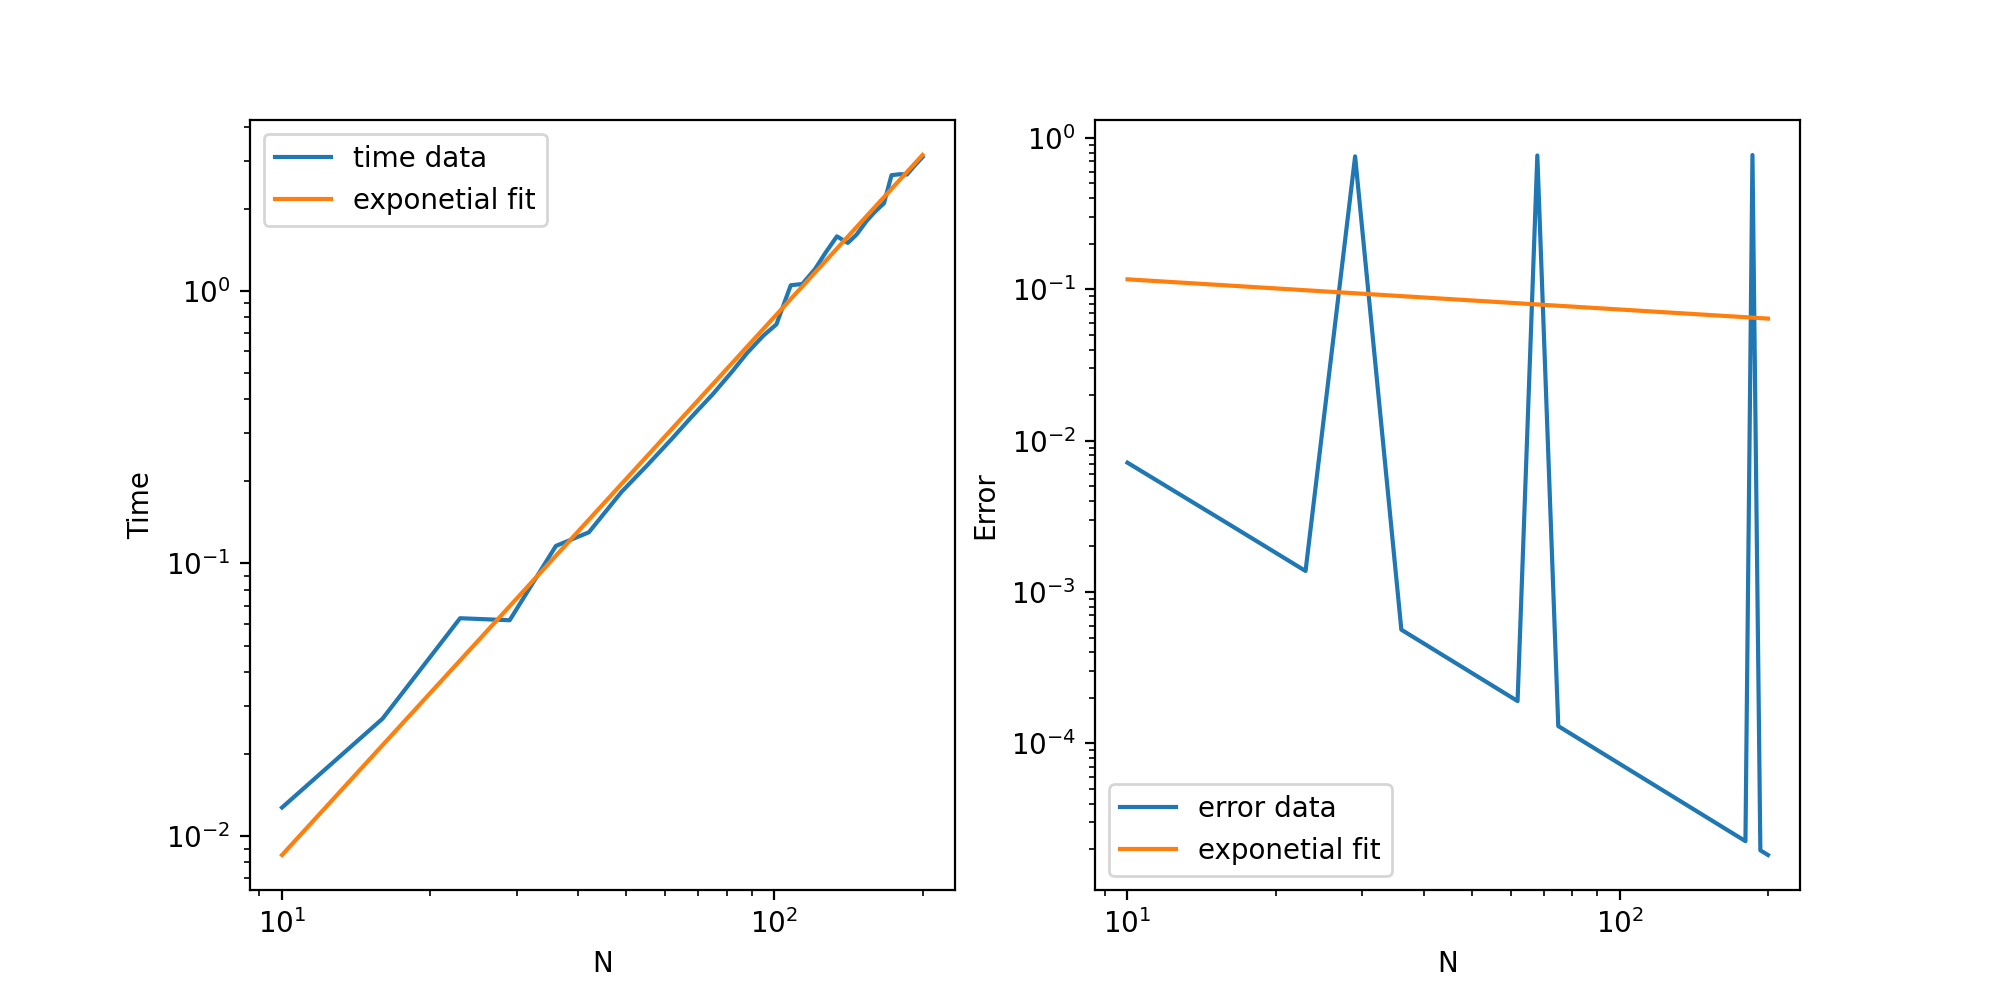

In [237]:
#Plot the fits

fig, ax = plt.subplots(1,2,figsize=(10, 5),dpi=100)

ax[0].plot(Ns, times, label = "time data")
ax[0].plot(Ns, f(Ns, *popt_times), label = "exponetial fit")
ax[0].set_xlabel("N")
ax[0].set_ylabel("Time")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(Ns, errors, label = "error data")
ax[1].plot(Ns, f(Ns, *popt_err), label = "exponetial fit")
ax[1].set_xlabel("N")
ax[1].set_ylabel("Error")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].legend();

These both appear to have produced good fits. We will now check the value of $\alpha$ obtained for both cases:

In [239]:
print(f"Time complexity : O(N^{popt_times[1]})")
print(f"Order of convergence : alpha = {-popt_err[1]}")

Time complexity : O(N^1.9738338218349338)
Order of convergence : alpha = 0.19942510717655976


These fits imply that the time complexity of the solution is roughly $\mathcal{O}(N^2)$, while the convergence of the problem is $\mathcal{O}(N^{-2})$

### Part 5: parallelisation
In this section, we will consider how your solution method could be parallelised; you do not need,
however, to implement a parallel version of your solution method.

**Comment on how your solution method could be parallelised.** Which parts (if any) would be trivial
to parallelise? Which parts (if any) would be difficult to parallelise? By how much would you expect
parallelisation to speed up your solution method?